In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate over the two classes
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

# Dataset paths
dataset_dir = "/content/drive/MyDrive/Pneumonia/chest_xray"
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Create DataFrames for train, validation, and test datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

# Convert labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# Print dataset sizes
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")

Train set size: 5216, Validation set size: 16, Test set size: 624


In [7]:
# Function to count categories in a given DataFrame
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")

# Count and display for train, validation, and test datasets
print("Image Counts per Category:")
count_categories(train_df, "Train")
count_categories(val_df, "Validation")
count_categories(test_df, "Test")

Image Counts per Category:
Train set:
  NORMAL: 1341
  PNEUMONIA: 3875
Validation set:
  NORMAL: 8
  PNEUMONIA: 8
Test set:
  NORMAL: 234
  PNEUMONIA: 390


**Have a good visualization with graphs with this code**

Train set:
  NORMAL: 1341
  PNEUMONIA: 3875
Validation set:
  NORMAL: 8
  PNEUMONIA: 8
Test set:
  NORMAL: 234
  PNEUMONIA: 390


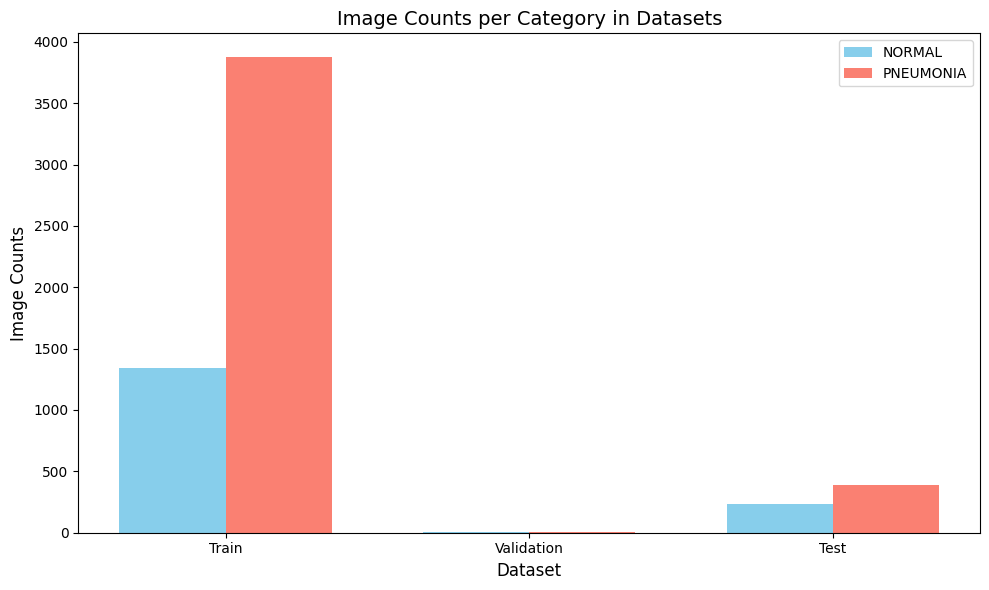

In [8]:
import matplotlib.pyplot as plt

# Function to count categories in a given DataFrame and return the counts as a dictionary
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")
    # Return the counts as a dictionary
    return {"dataset": dataset_name, "NORMAL": category_counts.get(0, 0), "PNEUMONIA": category_counts.get(1, 0)}

# Get counts for all datasets
train_counts = count_categories(train_df, "Train")
val_counts = count_categories(val_df, "Validation")
test_counts = count_categories(test_df, "Test")

# Organize data for plotting
datasets = [train_counts, val_counts, test_counts]
datasets_names = [d["dataset"] for d in datasets]
normal_counts = [d["NORMAL"] for d in datasets]
pneumonia_counts = [d["PNEUMONIA"] for d in datasets]

# Plotting
bar_width = 0.35
x = range(len(datasets_names))  # Index for datasets

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots
ax.bar(x, normal_counts, width=bar_width, label="NORMAL", color='skyblue')
ax.bar([i + bar_width for i in x], pneumonia_counts, width=bar_width, label="PNEUMONIA", color='salmon')

# Add labels and titles
ax.set_xlabel("Dataset", fontsize=12)
ax.set_ylabel("Image Counts", fontsize=12)
ax.set_title("Image Counts per Category in Datasets", fontsize=14)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(datasets_names)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

**Test to see if there is a leakage in the dataset**

In [9]:
import hashlib
import os

def get_image_hash(image_path):
    """Generate a SHA-256 hash for an image file."""
    with open(image_path, 'rb') as f:
        img_hash = hashlib.sha256(f.read()).hexdigest()
    return img_hash

def check_pairwise_leakage(data_dirs):

    dataset_hashes = {}

    # Compute image hashes for each dataset
    for dataset_name, directory in data_dirs.items():
        image_hashes = set()
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(root, file)
                    img_hash = get_image_hash(img_path)
                    image_hashes.add(img_hash)
        dataset_hashes[dataset_name] = image_hashes

    # Check for duplicates between dataset pairs
    leakage = {}
    dataset_names = list(data_dirs.keys())
    for i in range(len(dataset_names)):
        for j in range(i + 1, len(dataset_names)):
            set1 = dataset_hashes[dataset_names[i]]
            set2 = dataset_hashes[dataset_names[j]]
            overlap = set1.intersection(set2)
            leakage[f"{dataset_names[i]}-{dataset_names[j]}"] = overlap

    return leakage

# Define dataset directories
data_dirs = {
    "train": "datasets/chest_xray/train",
    "val": "datasets/chest_xray/val",
    "test": "datasets/chest_xray/test"
}

# Check for leakage
leakage = check_pairwise_leakage(data_dirs)

# Print results
for pair, duplicates in leakage.items():
    if duplicates:
        print(f"Leakage found between {pair}: {len(duplicates)} duplicate images")
    else:
        print(f"No leakage found between {pair}")


No leakage found between train-val
No leakage found between train-test
No leakage found between val-test


In [10]:
def remove_duplicates(duplicates, keep_in="train"):
    """
    Remove duplicate images, keeping them only in the specified dataset.

    Args:
        duplicates (dict): Dictionary of duplicate image information.
        keep_in (str): The dataset in which duplicates should be retained.
    """
    removed_count = 0

    for hash_value, instances in duplicates.items():
        for orig_dataset, orig_path, dup_dataset, dup_path in instances:
            if dup_dataset != keep_in:
                try:
                    os.remove(dup_path)
                    removed_count += 1
                    print(f"Removed {dup_path} (duplicate of {orig_path} in {orig_dataset})")
                except FileNotFoundError:
                    print(f"File {dup_path} already removed.")
    print(f"Total duplicates removed: {removed_count}")


if duplicates:
    remove_duplicates(duplicates, keep_in="train")  # Keep duplicates in the 'train' dataset
else:
    print("No data leakage found! therefore, nothing has been removed from any set")


No data leakage found! therefore, nothing has been removed from any set


**Tackle now the class imbalance**

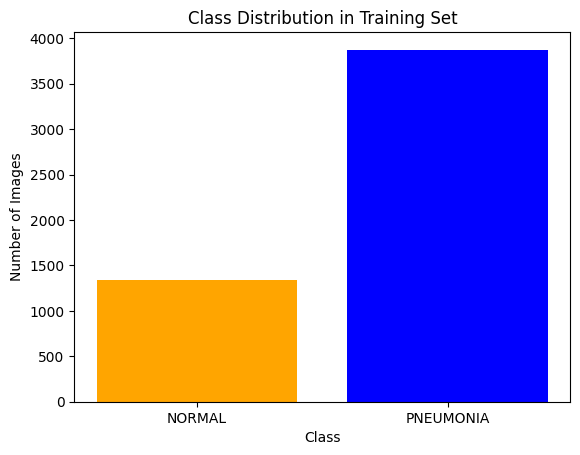

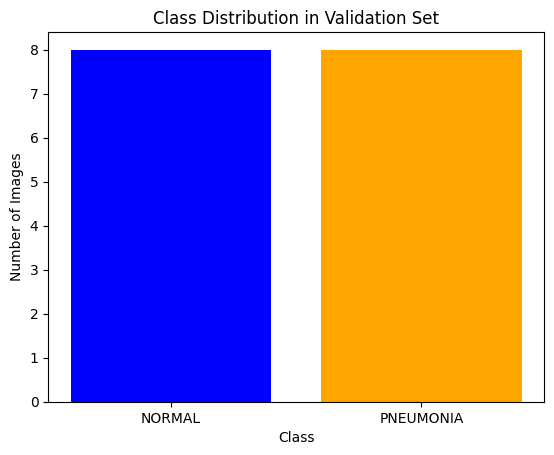

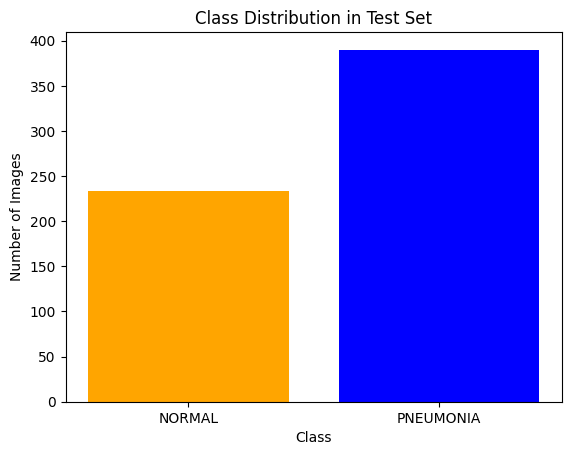

In [11]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, title):
    class_counts = df['label'].value_counts()
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
    plt.xticks([0, 1], ['NORMAL', 'PNEUMONIA'])
    plt.title(title)
    plt.ylabel('Number of Images')
    plt.xlabel('Class')
    plt.show()

plot_class_distribution(train_df, "Class Distribution in Training Set")
plot_class_distribution(val_df, "Class Distribution in Validation Set")
plot_class_distribution(test_df, "Class Distribution in Test Set")


**Resolve the imbalance in the training set for our case, The normal pictures are much lower than the Pneumonia ones, We do not want to have a very big numbers of pneumonia during prediction**

In [12]:
import os
import numpy as np
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Update the paths to reflect the actual location in Google Drive
train_dir = '/content/drive/MyDrive/Pneumonia/chest_xray/train'  # Update to your actual path
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Count the number of images in each class
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

# Calculate how many images we need to generate
num_to_generate = num_pneumonia - num_normal

# Set up an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Small rotations
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    zoom_range=0.1,  # Slight zoom
    brightness_range=(0.9, 1.1),  # Brightness adjustment
    fill_mode='nearest'  # Filling gaps with nearest pixel values
)

# Get the list of image paths in the normal directory
normal_images = [os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir)]

# Generate augmented images until we reach the desired count
generated_count = 0
while generated_count < num_to_generate:
    image_path = random.choice(normal_images)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((1,) + image.shape)  # Reshape to (1, height, width, channels)

    # Generate augmented images
    for batch in datagen.flow(image, batch_size=1):
        new_image = batch[0].astype(np.uint8)
        new_image_path = os.path.join(normal_dir, f'augmented_{generated_count}.jpg')
        cv2.imwrite(new_image_path, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
        generated_count += 1

        if generated_count >= num_to_generate:
            break

Number of NORMAL images: 3875
Number of PNEUMONIA images: 3875


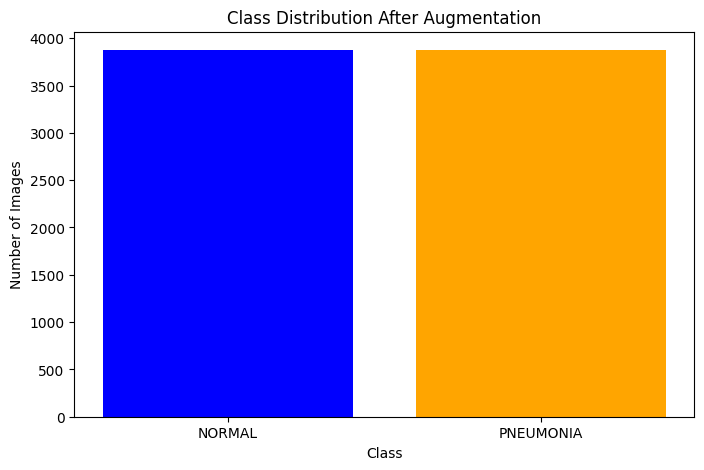

In [13]:
import matplotlib.pyplot as plt
import os

# Directory paths for the augmented data
normal_dir = '/content/drive/MyDrive/Pneumonia/chest_xray/train/NORMAL'
pneumonia_dir = '/content/drive/MyDrive/Pneumonia/chest_xray/train/PNEUMONIA'

# Count the number of images in each class
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

# Print the counts for verification
print(f"Number of NORMAL images: {num_normal}")
print(f"Number of PNEUMONIA images: {num_pneumonia}")

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(['NORMAL', 'PNEUMONIA'], [num_normal, num_pneumonia], color=['blue', 'orange'])
plt.title('Class Distribution After Augmentation')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()



**Prepare again the dataset for new way of solving the imbalance problem**
















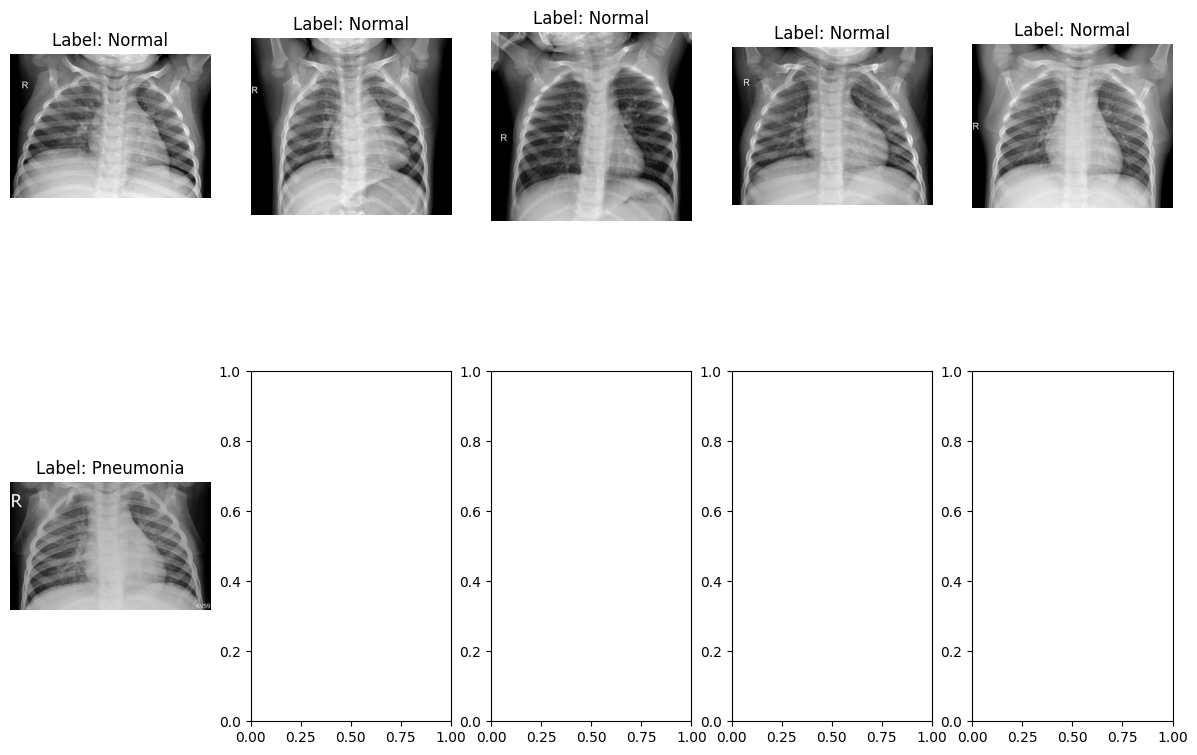

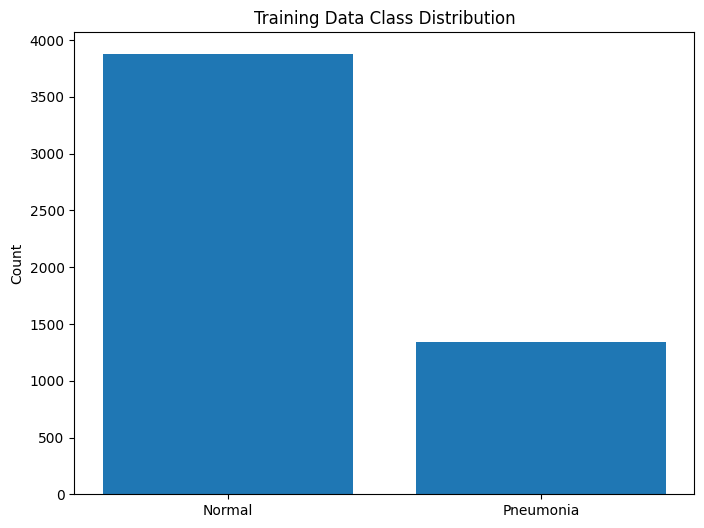

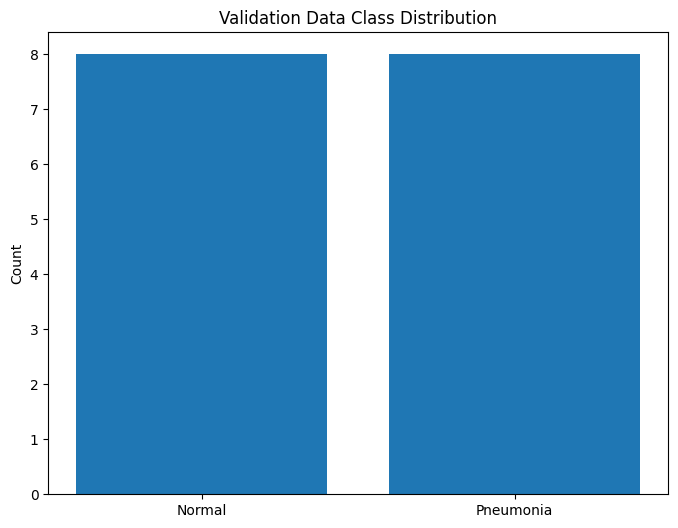

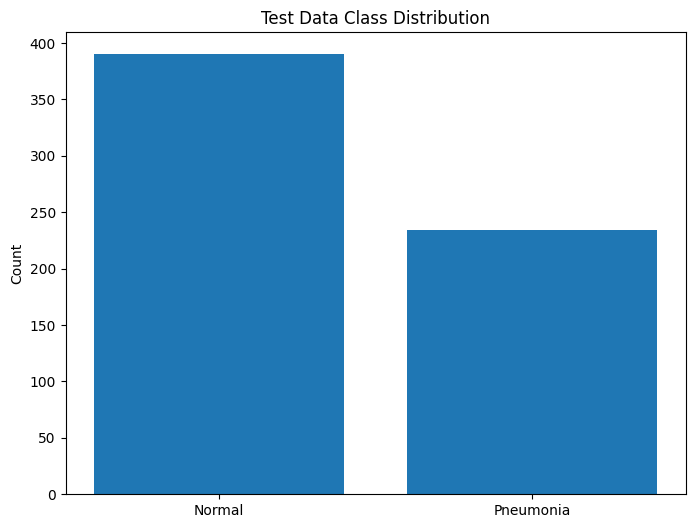

In [14]:
# Visualizing some samples from the dataset
def visualize_samples(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))

    # Visualize 5 NORMAL samples
    normal_samples = df[df['label'] == 0].iloc[:n_samples]
    for i in range(n_samples):
        img_path = normal_samples.iloc[i, 0]
        label = normal_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[0, i].axis('off')

    # Visualize 5 PNEUMONIA samples
    pneumonia_samples = df[df['label'] == 1].iloc[:n_samples]
    for i in range(n_samples):
        img_path = pneumonia_samples.iloc[i, 0]
        label = pneumonia_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[1, i].axis('off')

        plt.show()

# Show 5 samples from the training data
visualize_samples(train_df)

# Visualizing the class distribution
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], train_counts)
plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], val_counts)
plt.title("Validation Data Class Distribution")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], test_counts)
plt.title("Test Data Class Distribution")
plt.ylabel("Count")
plt.show()


For the using of the GPU, it will be important to use CUDA

In [15]:
# Check for multi-GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to prepare model for multi-GPU usage
def prepare_model_for_multigpu(model):
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    return model

In [16]:
# Define Dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for training and validation

# For Custom CNN (Grayscale Input)

train_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),  # Convert to grayscale (1 channel)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# For ResNet-18 (RGB Input)
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),
])

# Create datasets for both models
train_dataset_cnn = ImageDataset(train_df, transform=train_transform_cnn)
val_dataset_cnn = ImageDataset(val_df, transform=val_transform_cnn)

train_dataset_resnet = ImageDataset(train_df, transform=train_transform_resnet)
val_dataset_resnet = ImageDataset(val_df, transform=val_transform_resnet)

# DataLoader
batch_size = 32
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False)

**Try the Training by building a CNN model from scratch. This will help to compare the one using a pretrained model and the training from scratch**

In [18]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # Pooling layer
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)  # Raw logits

        if not self.training:  # Apply Softmax only during evaluation/testing
            return torch.softmax(logits, dim=1)
        return logits


In [19]:
model_from_scratch = CustomCNN().to(device)

model_from_scratch = prepare_model_for_multigpu(model_from_scratch)


In [20]:
# Training function with history tracking
def train_model_with_history(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [21]:
# Define loss function and optimizer for Custom CNN
criterion = nn.CrossEntropyLoss()
optimizer_from_scratch = optim.Adam(model_from_scratch.parameters(), lr=0.001)


In [22]:
print("Training Custom CNN Model (from scratch)...")

# Train the model
train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_model_with_history(
    model_from_scratch, train_loader_cnn, val_loader_cnn, criterion, optimizer_from_scratch, num_epochs=10
)

# Save the trained model
model_save_path = "trained_model.pth"  # Path to save the model
torch.save(model_from_scratch.state_dict(), model_save_path)
print(f"Model successfully saved to {model_save_path}")


Training Custom CNN Model (from scratch)...
Epoch [1/10] Train Loss: 0.3589, Train Acc: 86.52% | Val Loss: 0.6320, Val Acc: 56.25%
Epoch [2/10] Train Loss: 0.1301, Train Acc: 94.71% | Val Loss: 0.4217, Val Acc: 87.50%
Epoch [3/10] Train Loss: 0.0964, Train Acc: 96.26% | Val Loss: 0.4684, Val Acc: 81.25%
Epoch [4/10] Train Loss: 0.0998, Train Acc: 96.34% | Val Loss: 0.5771, Val Acc: 68.75%
Epoch [5/10] Train Loss: 0.0732, Train Acc: 97.39% | Val Loss: 0.3810, Val Acc: 87.50%
Epoch [6/10] Train Loss: 0.0632, Train Acc: 97.85% | Val Loss: 0.4640, Val Acc: 81.25%
Epoch [7/10] Train Loss: 0.0596, Train Acc: 97.81% | Val Loss: 0.4749, Val Acc: 81.25%
Epoch [8/10] Train Loss: 0.0528, Train Acc: 98.18% | Val Loss: 0.3452, Val Acc: 100.00%
Epoch [9/10] Train Loss: 0.0433, Train Acc: 98.45% | Val Loss: 0.3579, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0465, Train Acc: 98.24% | Val Loss: 0.3556, Val Acc: 100.00%
Model successfully saved to trained_model.pth


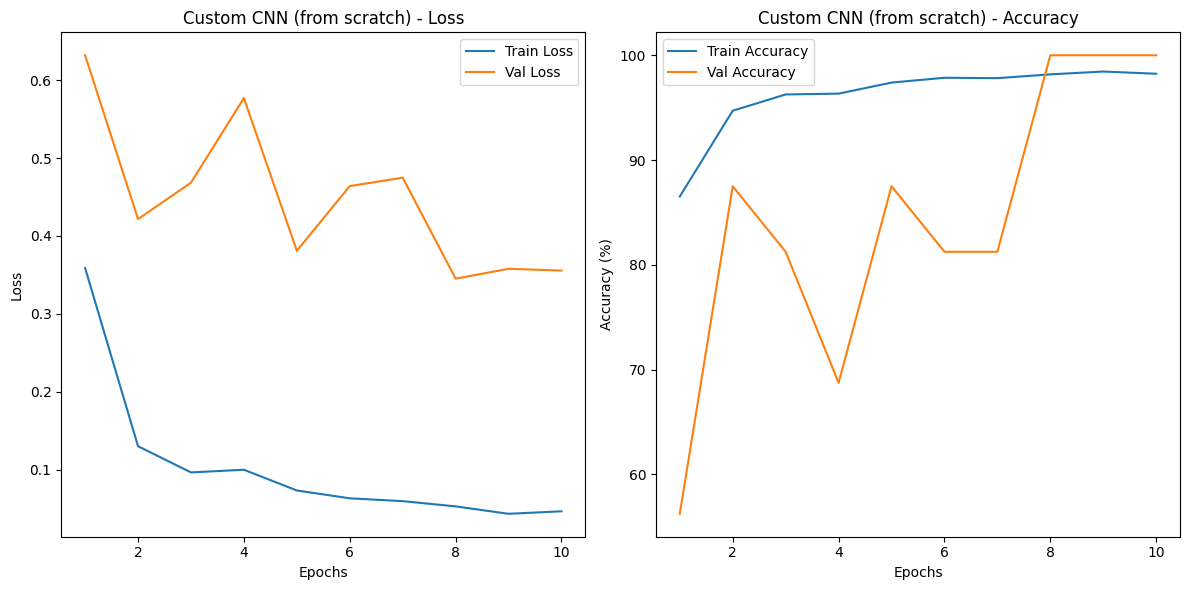

In [24]:
# Plot training and validation loss/accuracy for Custom CNN (from scratch)
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for Custom CNN (from scratch)
plot_training_history(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn, "Custom CNN (from scratch)")

**The ROC curve Area Under the Curve**

In [25]:
model = model_from_scratch

# Create the test dataset and dataloader
test_dataset = ImageDataset(test_df, transform=val_transform_cnn) # Use appropriate transform
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get predictions
predicted_vals = []
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_vals.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy

predicted_vals = np.array(predicted_vals) # Convert to a numpy array if needed

Area Under the ROC Curve (AUC): 0.89


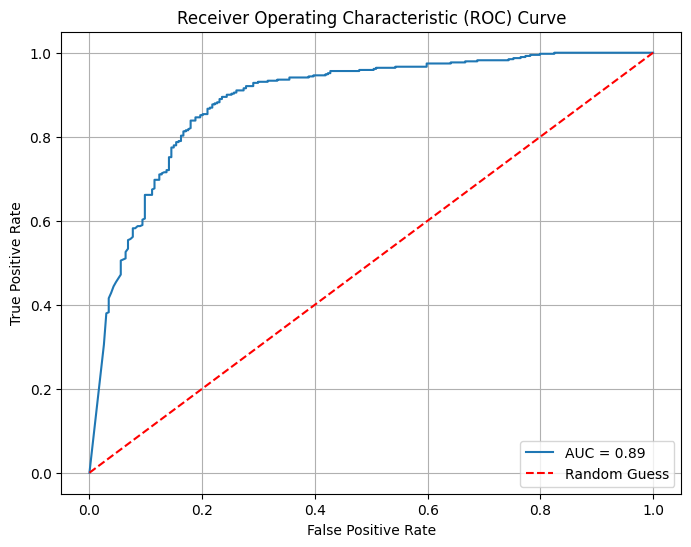

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained PyTorch model and test_loader is already defined

predicted_probs = []  # To store predicted probabilities
actual_labels = []    # To store actual labels

# Get predicted probabilities and actual labels
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Take probabilities of the positive class

        predicted_probs.extend(probs.cpu().numpy())  # Move probabilities to CPU and convert to numpy
        actual_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

predicted_probs = np.array(predicted_probs)
actual_labels = np.array(actual_labels)

# Calculate the ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probs)
auc_score = roc_auc_score(actual_labels, predicted_probs)

# Print the AUC Score
print(f"Area Under the ROC Curve (AUC): {auc_score:.2f}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**GRADCAM**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: 1 (0: Non-Pneumonia, 1: Pneumonia)
Predicted class: 1 (0: Non-Pneumonia, 1: Pneumonia)


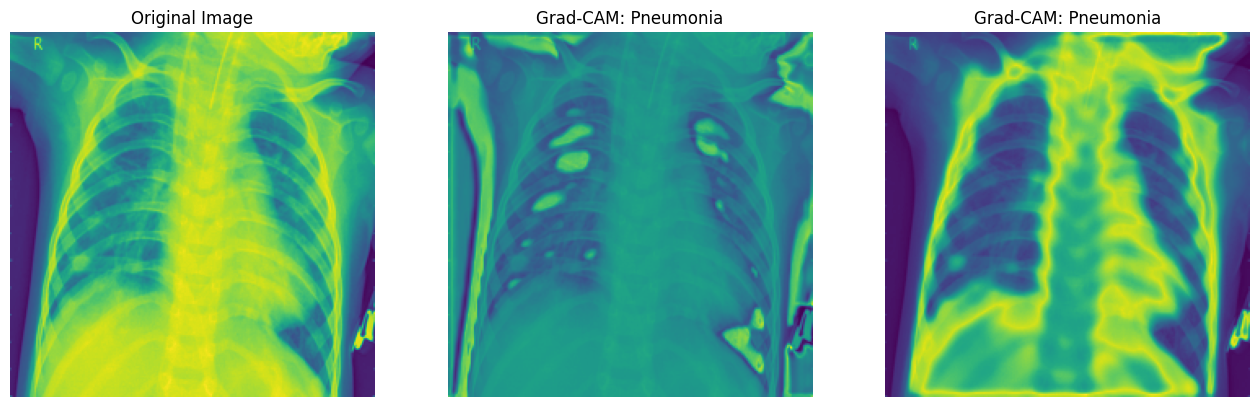

In [27]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import transforms
import os

# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        # Hook to capture gradients and activations
        self.hook_gradients()
        self.hook_activation()

    def hook_gradients(self):
        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Save gradients of the target layer
        self.target_layer.register_backward_hook(save_gradients)

    def hook_activation(self):
        def save_activation(module, input, output):
            self.activation = output  # Save activation maps of the target layer
        self.target_layer.register_forward_hook(save_activation)

    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        print(f"Predicted class: {pred_class} (0: Non-Pneumonia, 1: Pneumonia)")

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros(output.size(), device=input_tensor.device)
        one_hot_output[0, target_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam_map = torch.relu((weights * self.activation).sum(dim=1)).squeeze()

        # Normalize Grad-CAM
        gradcam_map = gradcam_map.cpu().detach().numpy()
        gradcam_map = cv2.resize(gradcam_map, (input_tensor.size(3), input_tensor.size(2)))
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())

        return gradcam_map, pred_class

# Select model and layer
# Ensure the correct target layer is specified here (replace `model.conv4` with your model's layer)
target_layer = model.conv4
gradcam = GradCAM(model, target_layer)

# Load an example image from the training set
image_path = "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}")

image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Grad-CAM and predictions
pneumonia_map, pneumonia_pred = gradcam.generate(input_tensor, target_class=1)
non_pneumonia_map, non_pneumonia_pred = gradcam.generate(input_tensor, target_class=0)

# Visualize the results
def overlay_gradcam(image, gradcam_map):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)  # Convert heatmap to grayscale
    overlay = np.float32(heatmap) / 255 + np.float32(image) / 255
    overlay = overlay / overlay.max()  # Normalize
    return np.uint8(255 * overlay)

original_image = ToPILImage()(input_tensor[0].cpu())
original_image = np.array(original_image)  # Convert PIL to numpy array

# Overlay Grad-CAM on original image
pneumonia_overlay = overlay_gradcam(original_image, pneumonia_map)
non_pneumonia_overlay = overlay_gradcam(original_image, non_pneumonia_map)

# Add classification labels
pneumonia_label = "Pneumonia" if pneumonia_pred == 1 else "Non-Pneumonia"
non_pneumonia_label = "Non-Pneumonia" if non_pneumonia_pred == 0 else "Pneumonia"

# Plot results
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Grad-CAM: {pneumonia_label}")
plt.imshow(pneumonia_overlay)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Grad-CAM: {non_pneumonia_label}")
plt.imshow(non_pneumonia_overlay)
plt.axis('off')

plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Probabilities: [0.5156021  0.48439792]
Predicted class: 0 (0: Non-Pneumonia, 1: Pneumonia)


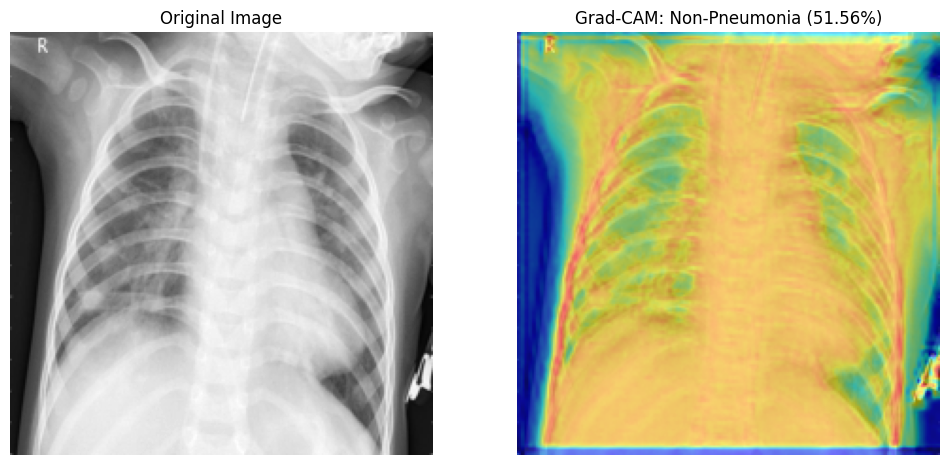

In [29]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import transforms
import os
import torch.nn as nn

# Define CustomCNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)
        if not self.training:
            return torch.softmax(logits, dim=1)  # Return probabilities during evaluation
        return logits

# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        self.hook_gradients()
        self.hook_activation()

    def hook_gradients(self):
        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Save gradients of the target layer
        self.target_layer.register_backward_hook(save_gradients)

    def hook_activation(self):
        def save_activation(module, input, output):
            self.activation = output  # Save activation maps of the target layer
        self.target_layer.register_forward_hook(save_activation)

    def generate(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)
        probabilities = output.squeeze().cpu().detach().numpy()
        pred_class = np.argmax(probabilities)
        print(f"Probabilities: {probabilities}")
        print(f"Predicted class: {pred_class} (0: Non-Pneumonia, 1: Pneumonia)")

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros(output.size(), device=input_tensor.device)
        one_hot_output[0, pred_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam_map = torch.relu((weights * self.activation).sum(dim=1)).squeeze()

        # Normalize Grad-CAM
        gradcam_map = gradcam_map.cpu().detach().numpy()
        gradcam_map = cv2.resize(gradcam_map, (input_tensor.size(3), input_tensor.size(2)))
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())

        return gradcam_map, probabilities, pred_class

# Load Model and Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
model.eval()  # Set to evaluation mode
target_layer = model.conv4
gradcam = GradCAM(model, target_layer)

image_path = "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}")

image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Grad-CAM and predictions
gradcam_map, probabilities, pred_class = gradcam.generate(input_tensor)

# Overlay Grad-CAM on Image
def overlay_gradcam(image, gradcam_map):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert heatmap to RGB

    # Convert image to 3 channels if it's grayscale
    if len(image.shape) == 2:  # If grayscale (2D array)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB

    overlay = np.float32(heatmap) / 255 + np.float32(image) / 255
    overlay = overlay / overlay.max()  # Normalize
    return np.uint8(255 * overlay)

original_image = ToPILImage()(input_tensor[0].cpu())
original_image = np.array(original_image)  # Convert PIL to numpy array
gradcam_overlay = overlay_gradcam(original_image, gradcam_map)

# Add classification label with probability
pred_label = f"Pneumonia ({probabilities[1]*100:.2f}%)" if pred_class == 1 else f"Non-Pneumonia ({probabilities[0]*100:.2f}%)"

# Plot Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM: {pred_label}")
plt.imshow(gradcam_overlay)
plt.axis('off')

plt.show()


**To download in my computer :**

In [32]:
from google.colab import files
files.download('/content/trained_model_Resnet18.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Create the Pretrained model**

In [30]:
# Load pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)  # Modify for binary classification
resnet18 = prepare_model_for_multigpu(resnet18)  # Apply multi-GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [31]:
# Define optimizer for ResNet-18
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.001)

# Train the Pretrained ResNet-18 Model
print("Training Pretrained ResNet-18 Model...")
train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet = train_model_with_history(
    resnet18, train_loader_resnet, val_loader_resnet, criterion, optimizer_resnet, num_epochs=10
)

# Save the trained model
model_save_path = "trained_model_Resnet18.pth"  # Path to save the model
torch.save(resnet18.state_dict(), model_save_path)
print(f"Model successfully saved to {model_save_path}")


Training Pretrained ResNet-18 Model...
Epoch [1/10] Train Loss: 0.1331, Train Acc: 95.30% | Val Loss: 0.1718, Val Acc: 93.75%
Epoch [2/10] Train Loss: 0.0845, Train Acc: 96.78% | Val Loss: 0.7780, Val Acc: 56.25%
Epoch [3/10] Train Loss: 0.0644, Train Acc: 97.51% | Val Loss: 1.4444, Val Acc: 68.75%
Epoch [4/10] Train Loss: 0.0522, Train Acc: 98.03% | Val Loss: 3.4936, Val Acc: 62.50%
Epoch [5/10] Train Loss: 0.0410, Train Acc: 98.41% | Val Loss: 0.1855, Val Acc: 87.50%
Epoch [6/10] Train Loss: 0.0397, Train Acc: 98.64% | Val Loss: 0.8313, Val Acc: 75.00%
Epoch [7/10] Train Loss: 0.0377, Train Acc: 98.50% | Val Loss: 1.2398, Val Acc: 50.00%
Epoch [8/10] Train Loss: 0.0307, Train Acc: 98.77% | Val Loss: 0.0909, Val Acc: 93.75%
Epoch [9/10] Train Loss: 0.0336, Train Acc: 98.70% | Val Loss: 0.0199, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0213, Train Acc: 99.23% | Val Loss: 0.0967, Val Acc: 93.75%
Model successfully saved to trained_model_Resnet18.pth


**ROC Curve and AUROC**

In [33]:
model = resnet18

# Create the test dataset and dataloader
test_dataset = ImageDataset(test_df, transform=val_transform_resnet)  # Use val_transform_resnet
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Get predictions
predicted_vals = []
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_vals.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy

predicted_vals = np.array(predicted_vals) # Convert to a numpy array if needed

<ipython-input-34-a3a04a054dc4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/trained_model_Resnet18.pth"))


Area Under the ROC Curve (AUC): 0.93


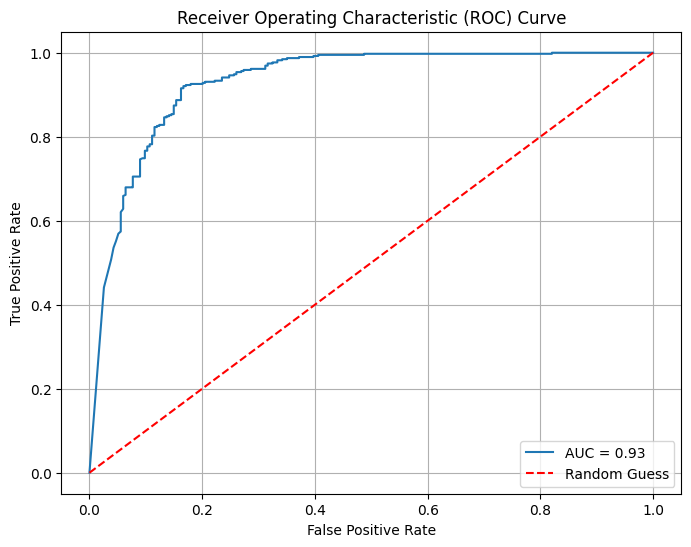

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

model = resnet18  # Assuming resnet18 is defined and initialized
model.load_state_dict(torch.load("/content/trained_model_Resnet18.pth"))

predicted_probs = []  # To store predicted probabilities
actual_labels = []    # To store actual labels

# Get predicted probabilities and actual labels
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Take probabilities of the positive class

        predicted_probs.extend(probs.cpu().numpy())  # Move probabilities to CPU and convert to numpy
        actual_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

predicted_probs = np.array(predicted_probs)
actual_labels = np.array(actual_labels)

# Calculate the ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probs)
auc_score = roc_auc_score(actual_labels, predicted_probs)

# Print the AUC Score
print(f"Area Under the ROC Curve (AUC): {auc_score:.2f}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: 1 (0: Non-Pneumonia, 1: Pneumonia)
Predicted class: 1 (0: Non-Pneumonia, 1: Pneumonia)


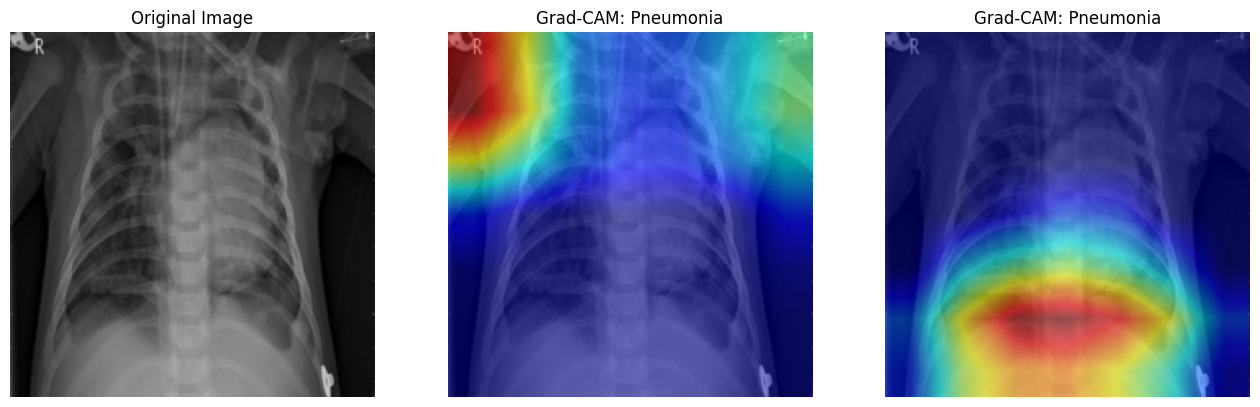

In [42]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import transforms
import os


model = resnet18

# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        # Hook to capture gradients and activations
        self.hook_gradients()
        self.hook_activation()

    def hook_gradients(self):
        def save_gradients(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Save gradients of the target layer
        self.target_layer.register_backward_hook(save_gradients)

    def hook_activation(self):
        def save_activation(module, input, output):
            self.activation = output  # Save activation maps of the target layer
        self.target_layer.register_forward_hook(save_activation)

    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        print(f"Predicted class: {pred_class} (0: Non-Pneumonia, 1: Pneumonia)")

        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros(output.size(), device=input_tensor.device)
        one_hot_output[0, target_class] = 1
        output.backward(gradient=one_hot_output)

        # Compute weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam_map = torch.relu((weights * self.activation).sum(dim=1)).squeeze()

        # Normalize Grad-CAM
        gradcam_map = gradcam_map.cpu().detach().numpy()
        gradcam_map = cv2.resize(gradcam_map, (input_tensor.size(3), input_tensor.size(2)))
        gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())

        return gradcam_map, pred_class

# Select model and layer
# Ensure the correct target layer is specified here (replace `model.conv4` with your model's layer)
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)

# Load an example image from the training set
image_path = "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}")

image = Image.open(image_path).convert('RGB')

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Grad-CAM and predictions
pneumonia_map, pneumonia_pred = gradcam.generate(input_tensor, target_class=1)
non_pneumonia_map, non_pneumonia_pred = gradcam.generate(input_tensor, target_class=0)

# Visualize the results
def overlay_gradcam(image, gradcam_map):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255  # Normalize heatmap to [0, 1]

    # Convert image to grayscale if necessary
    # if len(image.shape) == 3 and image.shape[2] == 3:  # Check if RGB
    #     image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert the heatmap to 3 channels to match the original image
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


    image = np.float32(image) / 255

    overlay = heatmap * 0.5 + image * 0.5  # Blend heatmap and original image (adjust weights as needed)
    overlay = overlay / overlay.max()  # Normalize overlay to [0, 1]
    return np.uint8(255 * overlay)  # Convert back to [0, 255]

original_image = ToPILImage()(input_tensor[0].cpu())
original_image = np.array(original_image)  # Convert PIL to numpy array

# Overlay Grad-CAM on original image
pneumonia_overlay = overlay_gradcam(original_image, pneumonia_map)
non_pneumonia_overlay = overlay_gradcam(original_image, non_pneumonia_map)

# Add classification labels
pneumonia_label = "Pneumonia" if pneumonia_pred == 1 else "Non-Pneumonia"
non_pneumonia_label = "Non-Pneumonia" if non_pneumonia_pred == 0 else "Pneumonia"

# Plot results
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Grad-CAM: {pneumonia_label}")
plt.imshow(pneumonia_overlay)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Grad-CAM: {non_pneumonia_label}")
plt.imshow(non_pneumonia_overlay)
plt.axis('off')

plt.show()


In [23]:
from google.colab import files
files.download('/content/trained_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>